# Peptides classification with subsequence string kernel

This notebook details the utilization of Scikit-Learn to search for the best Support Vector Machine (SVM) model for the classification of peptides sequences using the subsequence string kernel.

## 1. Dataset preparation

This example is about antimicrobial peptides (AMPs) classification. We used the data and experimental methodology of the research conducted by P. Bhadra and collaborators.

The data consists of a dataset with a 1:3 positive to negative ratio, AMP/non-AMP peptide sequences. The dataset containing AMP and non-AMP data is freely available at https://sourceforge.net/projects/axpep/files/. 

The original work employs a 10-fold cross-validation for training a Random Forest model and obtains an Matthews correlation coefficient (MCC) score of 0.90 and an area under the receiver operating characteristic curve (AUROC) of 0.98 in test dataset.

**Reference**: P. Bhadra, J. Yan, J. Li, S. Fong, and S. W. Siu. AmPEP: Sequence-based prediction of antimicrobial peptides using distribution patterns of amino acid properties and random forest. *Scientific Reports*, vol. 8, no. 1, pp. 1–10, 2018.

Installing the strkernels package.

In [ ]:
! pip install strkernels

Loading required packages.

In [1]:
from os import path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (make_scorer, 
                             matthews_corrcoef,
                             accuracy_score,
                             recall_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve)

from strkernels import SubsequenceStringKernel

random_seed = 1708  # for reproducing data splits

The first step involves loading the dataset and creating a dataframe.

In [2]:
# defining a function to create a dataframe from a FASTA file.

def read_fasta_to_dataframe(fasta_file):
    data = []
    with open(fasta_file, 'r') as file:
        sequence_id = None
        sequence = []
        
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id is not None:
                    data.append([sequence_id, ''.join(sequence)])
                sequence_id = line[1:]
                sequence = []
            else:
                sequence.append(line)
        
        if sequence_id is not None:
            data.append([sequence_id, ''.join(sequence)])
    
    df = pd.DataFrame(data, columns=['seqid', 'sequence'])
    return df

Loading the positive sequences.

In [3]:
amp_seqs_file_path = path.join('data', 'Bhadra-et-al-2018', 'train_AMP_3268.fasta')
amp_df = read_fasta_to_dataframe(amp_seqs_file_path)
amp_df['label'] = 1
amp_df

,seqid,sequence,label
0,AMP_1,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,1
1,AMP_2,AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...,1
2,AMP_3,AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTN...,1
3,AMP_4,AAFRGCWTKNYSPKPCL,1
4,AMP_5,AAGMGFFGAR,1
...,...,...,...
3263,AMP_3264,YIRDFITRRPPFGNI,1
3264,AMP_3265,GILDALTGIL,1
3265,AMP_3266,IFKAIWSGIKRLC,1
3266,AMP_3267,ILGKFCDEIKRIV,1


Loading the negative sequences.

In [4]:
amp_seqs_file_path = path.join('data', 'Bhadra-et-al-2018', 'train_nonAMP_9777.fasta')
non_amp_df = read_fasta_to_dataframe(amp_seqs_file_path)
non_amp_df['label'] = -1
non_amp_df

,seqid,sequence,label
0,nonamp_1,MNNNTTAPTYTLRGLQLIGWRDMQHALDYLFADGHLKQGTLVAINA...,-1
1,nonamp_2,MKSLLPLAILAALAVAALCYESHESMESYEVSPFTTRRNANTFISP...,-1
2,nonamp_3,MASVTDGKTGIKDASDQNFDYMFKLLIIGNSSVGKTSFLFRYADDT...,-1
3,nonamp_4,MASFQDRAQHTIAQLDKELSKYPVLNNLERQTSVPKVYVILGLVGI...,-1
4,nonamp_5,MRHRSGLRKLNRTSSHRQAMFRNMANSLLRHEVIKTTLPKAKELRR...,-1
...,...,...,...
9772,nonamp_9773,MDNEMTLTFLALSENEALARVAVTGFIAQLDPTIDELSEFKTVVSE...,-1
9773,nonamp_9774,MSKTVVRKNESLDDALRRFKRSVSKAGTLQESRKREFYEKPSVKRK...,-1
9774,nonamp_9775,MRHLVLIGFMGSGKSSLAQELGLALKLEVLDTDMIISERVGLSVRE...,-1
9775,nonamp_9776,MRDLKTYLSVAPVLSTLWFGSLAGLLIEINRFFPDALTFPFFLIRV...,-1


Creating a single dataframe with the positive and negative sequences.

In [5]:
data_df = pd.concat([amp_df, non_amp_df])
data_df

,seqid,sequence,label
0,AMP_1,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,1
1,AMP_2,AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...,1
2,AMP_3,AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTN...,1
3,AMP_4,AAFRGCWTKNYSPKPCL,1
4,AMP_5,AAGMGFFGAR,1
...,...,...,...
9772,nonamp_9773,MDNEMTLTFLALSENEALARVAVTGFIAQLDPTIDELSEFKTVVSE...,-1
9773,nonamp_9774,MSKTVVRKNESLDDALRRFKRSVSKAGTLQESRKREFYEKPSVKRK...,-1
9774,nonamp_9775,MRHLVLIGFMGSGKSSLAQELGLALKLEVLDTDMIISERVGLSVRE...,-1
9775,nonamp_9776,MRDLKTYLSVAPVLSTLWFGSLAGLLIEINRFFPDALTFPFFLIRV...,-1


Separating 75% of the sequences for training and 25% for testing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_df['sequence'], 
                                                    data_df['label'], 
                                                    stratify=data_df['label'], 
                                                    random_state=random_seed)
print('Train sequences:',len(X_train))
print('Test sequences:',len(X_test))

Train sequences: 9783
Test sequences: 3262


## 2. Hyperparameters selection

Now, we will search for the best value for the hyperparameters maximum subsequence length (maxlen) and decay factor (ssk_lambda) of the subsequence string kernel for this dataset. 

For better performance, we will only use 10% of the training samples in hyperparameter selection.

In [7]:
X_train_df = pd.concat([X_train, y_train], axis=1)
X_train_df

,sequence,label
4763,MNLNNDHGPDPENILPIKGNRNLQFIKPTITNENILVGEYSYYDSK...,-1
6565,MKAFQRDFIEFAIERGVLKFGEFTLKSGRVSPYFFNAGLFNRGGDL...,-1
2669,MKSVITISASLAISLMLCCTAQANDHKILGVIAMPRNETNDLALKL...,-1
4087,MALAYDGAIQRLIDSFASLPGIGPKGAQRIAFYLLQAPDAESQRLV...,-1
5891,MPDEMIEVPCPICQKSVPWINESTFRPFCSKRCQLIDLGEWAAEEK...,-1
...,...,...
9349,MTTPIIVTGTDTGVGKTVFSAALAGALEATYWKPVQAGLDEETDRL...,-1
4886,MIFYLHGFDATSPGNHEKMRQLQFIDPDVRLISYSTLHPKHDMQHL...,-1
2747,MSEKKLKITQVRSVIGSTKKQKATIKALGLGRPNYHVDKEDNPCLR...,-1
3898,MIQMQSMLDAADNSGARSVMCIKVLGGSHRRYAHIGDVIKVTVKEA...,-1


In [8]:
X_train_pos = X_train_df[X_train_df['label'] == 1]
X_train_neg = X_train_df[X_train_df['label'] == -1]

X_train_pos_sampled = X_train_pos.sample(n=len(X_train_pos) // 10, random_state=random_seed)
X_train_neg_sampled = X_train_neg.sample(n=len(X_train_neg) // 10, random_state=random_seed)

X_train_sampled_df = pd.concat([X_train_pos_sampled, X_train_neg_sampled])
X_train_sampled_df

,sequence,label
2621,SQLGDLGSGAGQGGGGGGSIRAAGGAFGKLEAAREEEFFYKKQKEQ...,1
2187,MVFAYAPTCARCKSIGARYCGYGYLNRKGVSCDGQTTINSCEDCKR...,1
570,FLLFPLMCKIQGKC,1
1826,KQEGRDHDKSKGHFHMIVIHHKGGQAHHG,1
2274,PVVDTTGNNPLQQQEEYYV,1
...,...,...
3299,MSKPDLDAFLHGDDAALRETNRRLESMPAEDRVRWALEHLPPQHVL...,-1
2919,MEVQKEAQRIMTLSVWKMYHSRMQRGGLRLHRSLQLSLVMRSAREL...,-1
5336,MKSKPDDRRDNVDRIQQSIDNTIENIHETNEMIENTNREKNKDDLK...,-1
602,MATTIKPLEDRVLVQPLEAEQTTASGLVIPDTAKEKPQEGKVISAG...,-1


In [9]:
X_train_sampled = X_train_sampled_df['sequence']
y_train_sampled = X_train_sampled_df['label']

Creating the subsequence string kernel instance.

In [10]:
subsequence_kernel = SubsequenceStringKernel()

Running grid search with 10-fold cross-validation for searching the better subsequence string kernel hyperparameters.

In [11]:
# create a support vector classifier with the kernel
clf = SVC(kernel=subsequence_kernel)

# set parameters for grid search
param_grid = {
    'kernel__maxlen': [3, 4, 5, 6, 7],
    'kernel__ssk_lambda': [0.01, 0.25, 0.5, 0.75, 1.0],
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train_sampled, y_train_sampled)

# get the best parameters
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# save all grid search results to a CSV file with current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_grid_1 = f'grid_search_results_{current_time}.csv'
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(filename_grid_1, index=False)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[CV 8/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.889 total time= 3.3min
[CV 4/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.660 total time= 3.3min
[CV 6/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.860 total time= 3.3min
[CV 2/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.785 total time= 3.3min
[CV 1/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.811 total time= 3.3min
[CV 5/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.762 total time= 3.3min
[CV 3/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.751 total time= 3.4min
[CV 7/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.774 total time= 3.4min
[CV 10/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.740 total time= 3.4min
[CV 9/10] END kernel__maxlen=3, kernel__ssk_lambda=0.01;, score=0.830 total time= 3.4min
[CV 1/10] END kernel__maxlen=3, kernel__ssk_lambda=0.25;, score=0.811 total time= 3.5min
[CV 3/10] END kernel

grid_search_results_20241031_233934.csv


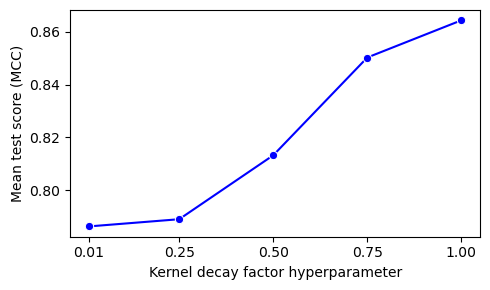

In [12]:
print(filename_grid_1)
grid_1_results_df = pd.read_csv(filename_grid_1)
grid_1_results_df = grid_1_results_df[grid_1_results_df['param_kernel__maxlen'] == 4]

plt.figure(figsize=(5, 3))
sns.lineplot(x='param_kernel__ssk_lambda', y='mean_test_score', data=grid_1_results_df, marker='o', color='b')
plt.xticks(ticks=grid_1_results_df['param_kernel__ssk_lambda'].unique())
plt.xlabel('Kernel decay factor hyperparameter')
plt.ylabel('Mean test score (MCC)')
plt.tight_layout()
plt.show()

In [13]:
# create a support vector classifier with the kernel
clf = SVC(kernel=subsequence_kernel)

# set parameters for grid search
param_grid = {
    'kernel__maxlen': [4],
    'kernel__ssk_lambda': [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7],
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train_sampled, y_train_sampled)

# get the best parameters
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# save all grid search results to a CSV file with current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_grid_2 = f'grid_search_results_{current_time}.csv'
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(filename_grid_2, index=False)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 5/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.762 total time= 3.9min
[CV 6/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.860 total time= 4.0min
[CV 8/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.917 total time= 4.0min
[CV 2/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.844 total time= 4.0min
[CV 1/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.919 total time= 4.0min
[CV 4/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.695 total time= 4.0min
[CV 3/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.864 total time= 4.0min
[CV 7/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.888 total time= 4.1min
[CV 9/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;, score=0.830 total time= 3.9min
[CV 1/10] END kernel__maxlen=4, kernel__ssk_lambda=0.9;, score=0.891 total time= 3.9min
[CV 10/10] END kernel__maxlen=4, kernel__ssk_lambda=0.8;,

grid_search_results_20241101_003014.csv


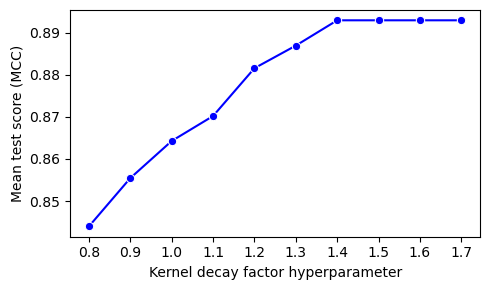

In [14]:
print(filename_grid_2)
grid_2_results_df = pd.read_csv(filename_grid_2)

plt.figure(figsize=(5, 3))
sns.lineplot(x='param_kernel__ssk_lambda', y='mean_test_score', data=grid_2_results_df, marker='o', color='b')
plt.xticks(ticks=grid_2_results_df['param_kernel__ssk_lambda'].unique())
plt.xlabel('Kernel decay factor hyperparameter')
plt.ylabel('Mean test score (MCC)')
plt.tight_layout()
plt.show()

Searching a better C hyperparameter of SVM.

In [15]:
# create a support vector classifier with the kernel
clf = SVC(kernel=subsequence_kernel)

# set parameters for grid search
param_grid = {
    'kernel__maxlen': [4],
    'kernel__ssk_lambda': [1.4],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train_sampled, y_train_sampled)

# get the best parameters
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# save all grid search results to a CSV file with current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_grid_3 = f'grid_search_results_{current_time}.csv'
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(filename_grid_3, index=False)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 6/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 3.9min
[CV 8/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 3.9min
[CV 1/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 4.0min
[CV 5/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 4.0min
[CV 7/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 4.0min
[CV 2/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 4.0min
[CV 4/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 4.0min
[CV 3/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 4.0min
[CV 10/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.000 total time= 3.9min
[CV 9/10] END C=0.01, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.0

grid_search_results_20241101_005633.csv


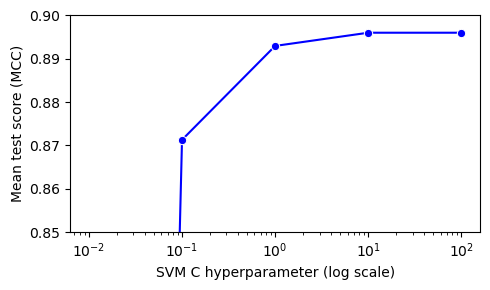

In [16]:
print(filename_grid_3)
grid_3_results_df = pd.read_csv(filename_grid_3)

plt.figure(figsize=(5, 3))
sns.lineplot(x='param_C', y='mean_test_score', data=grid_3_results_df, marker='o', color='b')
plt.xticks(ticks=grid_3_results_df['param_C'].unique())
plt.xscale('log')
plt.ylim(0.85, 0.9)
plt.xlabel('SVM C hyperparameter (log scale)')
plt.ylabel('Mean test score (MCC)')
plt.tight_layout()
plt.show()

In [17]:
# create a support vector classifier with the kernel
clf = SVC(kernel=subsequence_kernel)

# set parameters for grid search
param_grid = {
    'kernel__maxlen': [4],
    'kernel__ssk_lambda': [1.4],
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

mcc_scorer = make_scorer(matthews_corrcoef)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=mcc_scorer, 
                           cv=10,
                           n_jobs=-1, 
                           verbose=3)

# fit the model to the training data
grid_search.fit(X_train_sampled, y_train_sampled)

# get the best parameters
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# save all grid search results to a CSV file with current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_grid_4 = f'grid_search_results_{current_time}.csv'
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(filename_grid_4, index=False)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.925 total time= 3.9min
[CV 4/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.868 total time= 3.9min
[CV 3/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.921 total time= 4.0min
[CV 8/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.916 total time= 4.0min
[CV 7/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.870 total time= 4.0min
[CV 6/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=1.000 total time= 4.0min
[CV 2/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.881 total time= 4.0min
[CV 5/10] END C=1, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.760 total time= 4.0min
[CV 1/10] END C=2, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.921 total time= 4.0min
[CV 3/10] END C=2, kernel__maxlen=4, kernel__ssk_lambda=1.4;, score=0.921 total time= 4.0min
[CV 10/

grid_search_results_20241101_014733.csv


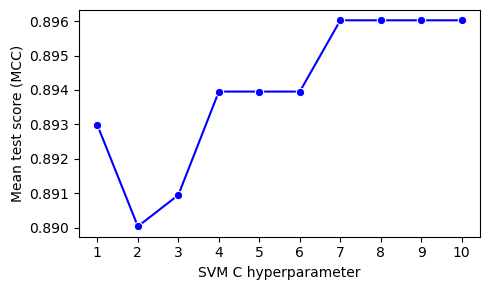

In [18]:
print(filename_grid_4)
grid_4_results_df = pd.read_csv(filename_grid_4)

plt.figure(figsize=(5, 3))
sns.lineplot(x='param_C', y='mean_test_score', data=grid_4_results_df, marker='o', color='b')
plt.xticks(ticks=grid_4_results_df['param_C'].unique())
plt.xlabel('SVM C hyperparameter')
plt.ylabel('Mean test score (MCC)')
plt.tight_layout()
plt.show()

### 3. Best model evaluation

Training the model with full training set.

In [ ]:
# create a kernel
subsequence_kernel = SubsequenceStringKernel(maxlen=4, ssk_lambda=1.4)

# create a support vector classifier with the kernel
clf = SVC(C=7.0, kernel=subsequence_kernel)

# train the classifier
clf.fit(X_train, y_train)

Performing the classification on the test dataset and obtaining the scores predicted.

In [20]:
pred_scores = clf.decision_function(X_test)

Plotting the ROC curve.

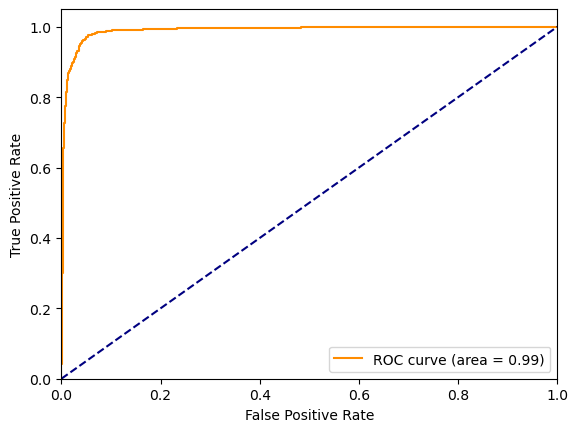

In [21]:
def plot_roc_curve(y_true, y_score):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a binary classifier.

    Args:
        y_true: True binary labels.
        y_score: Predicted probabilities or decision function scores.

    Returns:
        None
    """

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, pred_scores)

Defining sequence labels from scores.

In [22]:
pred_labels = np.where(pred_scores > 0, 1, -1)

Calculating and showing evaluation metrics.

In [49]:
MCC = round(matthews_corrcoef(y_test, pred_labels), 2)
accuracy = round(accuracy_score(y_test, pred_labels), 2)
sensitivity = round(recall_score(y_test, pred_labels), 2)
TN, FP, FN, TP = confusion_matrix(y_test, pred_labels).ravel()
specificity = round(TN / (TN + FP), 2)
AUROC = round(roc_auc_score(y_test, pred_scores), 2)

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUROC:", AUROC)

MCC: 0.89
Accuracy: 0.96
Sensitivity: 0.94
Specificity: 0.97
AUROC: 0.99


We observe that the best SVM model achieved a better AUROC score than the original tool, indicating good performance for the proposed problem.